# Hour Glass Potential

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dgutils import colors as col
import dgutils

from numpy import pi as π
from scipy import integrate
from scipy.constants import hbar as ħ
from scipy.constants import k
from scipy.special import ellipe
from scipy.special import ellipk
import numpy.ma as ma

# Notebook display options
%config InlineBackend.figure_format = 'svg'

# plot style
plot_style = {'aps':'../include/aps.mplstyle', 'notebook':'../include/notebook.mplstyle', 'sans':'../include/sans.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['sans'])

figsize = plt.rcParams['figure.figsize']

π = np.pi
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Nanopore Potential

In [2]:
# Tested and working with hourglass_potential_test.nb
# Note that python and Mathematica use the same definition for the elliptical integrals, but c++ uses a different one! 
# https://www.boost.org/doc/libs/1_82_0/libs/math/doc/html/math_toolkit/ellint/ellint_1.html

def D(z,w,L):
    return (np.tanh(2*z/w)**2 / np.tanh(L/w)**2 - 1)

def R(x,Rₒ,a,w,L):
    '''The radius of the hourglass as a function of position along the pore.'''
    
    return Rₒ + a*(np.tanh(2*x/w)**2 / np.tanh(L/w)**2 - 1)

def u9(x):
    prefac = 1.0/(240*(1-x**2)**9)
    t1 = (1091 + 11156*x**2 + 16434*x**4 + 4052*x**6 + 35*x**8)*ellipe(x**2)
    t2 = -8*(1 - x**2)*(1 + 7*x**2)*(97 + 134*x**2 + 25*x**4)*ellipk(x**2)
    return prefac*(t1+t2)*np.heaviside(1-x,1)
                
def u3(x):
    prefac = 2.0/(1.0-x**2)**3
    t1 = (7+x**2)*ellipe(x**2)
    t2 = -4*(1-x**2)*ellipk(x**2)
    return prefac*(t1+t2)
  
def U_pore(x,y,z,Rₒ,a,δ,L):
    '''The Lennard-Jones potential experienced by a 4He atom at postion (x,y,z) inside a nanpore.'''
    n = 0.078 # 1/Å^3
    ε = 10.22 # K
    σ = 2.628 # Å
    
    r = np.sqrt(x**2 + y**2)
    _R = R(z,Rₒ,a,δ,L)
    x̄ = r/_R
    σ̄ = σ/_R
    
    return  π*n*ε*σ**3/3.0 * (σ̄**9 * u9(x̄) - σ̄**3 * u3(x̄))

## Properties of the Nanopores

In [3]:
L = 100
Rₒ = 12
w = 3
δR = 4

z = np.linspace(-L/2,L/2,10000)
y = np.linspace(-Rₒ,Rₒ,10000)
Y,Z = np.meshgrid(y,z)

### Investigating the Deformation

Text(0, 0.5, '$D(z)$')

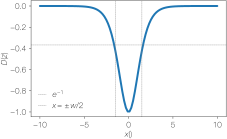

In [4]:
_z = np.linspace(-10,10,100)
plt.plot(_z,D(_z,w,L), lw=2)
plt.axhline(y=-1/np.exp(1), label="$e^{-1}$", color='grey', ls='--')
plt.axvline(x=-w/2, label='$x=\pm w/2$', color='grey', ls='--')
plt.axvline(x=w/2,color='grey', ls='--')
plt.legend()
plt.xlabel(r'$x  ()$')
plt.ylabel(r'$D(z)$')

### Generate the Slice of the Potential

In [5]:
generate = False

if generate:
    U = U_pore(0.0,Y,Z,Rₒ,δR,w,L)
    np.savez('../data/U_hourglass.npz',U)
    Umask = ma.masked_invalid(U)
else:
    U = np.load('../data/U_hourglass.npz')
    Umask = ma.masked_invalid(U['arr_0'])

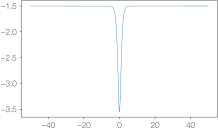

In [6]:
zz = np.linspace(-50,50,1000)
plt.plot(zz,U_pore(0,0,zz,12,3,3,100))

TeX  NOT subset; don't know how to subset; dropped
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


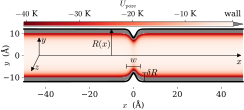

In [7]:
from mpl_toolkits.axes_grid1 import axes_size
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


def plot_hourglass(_ax,Umask,w,δR,L):
    cmap = plt.get_cmap('Reds_r').copy()
    cmap.set_extremes(under='w', over='grey')
    
    im = _ax.imshow(Umask.T, extent=[-L/2,L/2,-Rₒ,Rₒ], cmap=cmap, vmax=-1, rasterized=False)
    _ax.plot(z,R(z,Rₒ,δR,w,L), color='k', lw=1.5)
    _ax.plot(z,-R(z,Rₒ,δR,w,L), color='k', lw=1.5)
    _ax.set_ylim(-1.2*Rₒ,1.2*Rₒ);
    _ax.set_xlabel(r'$x$  (Å)')
    _ax.set_ylabel(r'$y$  (Å)', labelpad=-7)
   
    # Colorbar
    ax_divider = make_axes_locatable(ax)
    cb_ax = ax_divider.append_axes("top", size="7%", pad="-4%")
    cb = fig.colorbar(im, cax=cb_ax, orientation='horizontal',extend='max', ticks=[-40,-30,-20,-10,-1])
    cb.set_label(r'$U_{\rm pore}$', labelpad=4, loc='center')
    cb_ax.xaxis.set_label_position('top')
    cb_ax.xaxis.set_ticks_position('top')
    
    cb.ax.set_xticklabels(['$-40$ K', '$-30$ K', '$-20$ K', '$-10$ K', 'wall'])


    for spine in ['top','right','bottom','left']:
        _ax.spines[spine].set_visible(False)
    
    # Setup an axis
    _ax.text(L/2-3,-4,'$x$')
    _ax.annotate("", xy=(L/2, 0), xytext=(-L/2+7, 0),  
                arrowprops=dict(arrowstyle='-|>',fc='k',mutation_scale=8,lw=0.5, shrinkA=0.0))
    
    _ax.text(-L/2+8,6,'$y$')
    _ax.annotate("", xy=(-L/2+7, 3*Rₒ/4), xytext=(-L/2+7, 0),  
                arrowprops=dict(arrowstyle='-|>', fc='k',mutation_scale=8, lw=0.5, shrinkA=0.0))
    
    _ax.text(-L/2+5,-6.5,'$z$')
    _ax.annotate("", xy=(-L/2+3, -3*Rₒ/4+1), xytext=(-L/2+7, 0), 
                arrowprops=dict(arrowstyle='-|>', fc='k',mutation_scale=8, lw=0.5, shrinkA=0.0))
             
    # Measuring Bars
    ht = -5
    w = 4
    _ax.annotate("", xy=(-w, ht), xytext=(w, ht),  
                arrowprops=dict(arrowstyle='|-|',mutation_scale=2, lw=0.5))
    _ax.text(0,-4,'$w$',ha='center',va='bottom')
    
    w = 5
    _ax.annotate("", xy=(w, -Rₒ), xytext=(w, -Rₒ+4),  
                arrowprops=dict(arrowstyle='|-|',mutation_scale=2, lw=0.5, shrinkA=0, shrinkB=0))
    _ax.text(w+1,-Rₒ+4,'$\delta R$',ha='left',va='center')
    
    # Radius Label
    _ax.text(-19,4,'$R(x)$')
    _ax.annotate("", xy=(-10, Rₒ), xytext=(-10, 0), 
                arrowprops=dict(arrowstyle='-|>',fc='k',mutation_scale=8,lw=0.5, shrinkA=0.0, shrinkB=0))
    

plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    plot_hourglass(ax,Umask,w,δR,L)
    plt.savefig('../figures/hourglass_potential.pdf')
    plt.savefig('../figures/hourglass_potential.svg')

In [8]:
r = np.linspace(0,Rₒ-0.5,10000)
w = 3
x_labels = ['$x=0$','$|x|=w/5$','$|x|=w/4$','$|x|=w/3$','$|x|=w/2$','$|x|=w$','$|x|=2w$','$|x|=L/2$']
_x = [0,w/5,w/4,w/3,w/2,w,2*w,L/2]

Uplot = []
for cx in _x:
    Uplot.append(U_pore(r,0.0,cx,Rₒ,δR,w,L))

In [9]:
def plot_hourglass_potential_cuts(_ax,r,_x,Uplot,Rₒ):
    x_colors = dgutils.colors.get_linear_colors('Spectral',len(_x))
    for i,cx in enumerate(_x):
        _ax.plot(r/Rₒ, Uplot[i], color=x_colors[i],label=x_labels[i] )
    _ax.set_ylim(-42,42)
    _ax.set_xlim(0,1)
    _ax.set_xlabel('$^4$He Distance from Axis  $\;\;r/R_0$')
    _ax.set_ylabel(r'Hourglass Potential $\;\; U_{\rm pore}$  (K)')
    _ax.legend(loc=(1.01,0.225),ncol=1)

TeX  NOT subset; don't know how to subset; dropped
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


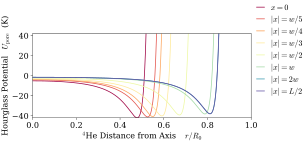

In [12]:
plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(1,1,constrained_layout=True,figsize=(1.25*figsize[0],figsize[1]))
    plot_hourglass_potential_cuts(ax,r,_x,Uplot,Rₒ)
    plt.savefig('../figures/hourglass_U.pdf')
    plt.savefig('../figures/hourglass_U.svg')

TeX  NOT subset; don't know how to subset; dropped
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


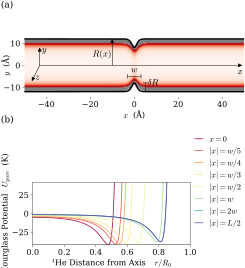

In [11]:
plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    figsize = plt.rcParams['figure.figsize']
    fig = plt.figure(figsize=(figsize[0],3.6), constrained_layout=True)
    fig_hg,fig_U = fig.subfigures(nrows=2,ncols=1, height_ratios=[1,1.3])
    
    ax_hg = fig_hg.subplots(1,1)
    plot_hourglass(ax_hg,Umask,w,δR,L)
    fig_hg.text(0.01,1.1,'(a)',ha='left',va='top')
      
    ax_U = fig_U.subplots(1,1)
    plot_hourglass_potential_cuts(ax_U,r,_x,Uplot,Rₒ)
    fig_U.text(0.01,1.07,'(b)',ha='left',va='top')

    plt.savefig('../figures/hourglass_potential_U.pdf')